## This is a title

In [42]:
import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import zscore

from assembly_name import ass2name

In [5]:
dfs = dict()
for assembly in [x[0].split("/")[1] for x in os.walk("gimme_smooth") if len(x[0].split("/")) > 1]:
    try:
        dfs[assembly] = pd.read_csv(f"gimme_smooth/{assembly}/activity.bayesianridge.score.out.txt", sep="\t", comment="#", index_col=0)
    except FileNotFoundError:
        continue

In [6]:
# del dfs["Bl71nemr"]
del dfs["ce11"]
del dfs["dm6"]
del dfs["ARS-UCD1.2"]
del dfs["Spur_5.0"]
del dfs["Phmamm_MTP2014"]

print(dfs.keys())

dict_keys(['GRCg6a', 'mm10', 'ASM318616v1', 'danRer11', 'xenTro9', 'Astyanax_mexicanus-2.0', 'Bl71nemr', 'ASM223467v1'])


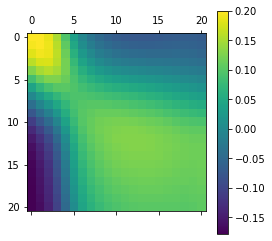

In [7]:
df1 = dfs["xenTro9"]
df2 = dfs["danRer11"]
corr = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'].T

im = plt.matshow(corr.values, aspect=len(df2.columns)/len(df1.columns))
plt.colorbar(im)

In [14]:
def local_maximum(in_array, radius=4):
    diam = 2 * radius + 1
    pad_array = np.pad(in_array, radius, 'minimum')
    
    threshold = max(0, np.quantile(in_array, 0.5))
    out_array = in_array > threshold
    for x_off, y_off in itertools.product(range(diam), repeat=2):
        x_stop = x_off-diam + 1 if x_off-diam + 1 != 0 else None
        y_stop = y_off-diam + 1 if y_off-diam + 1 != 0 else None
        out_array &= in_array >= pad_array[slice(x_off, x_stop), slice(y_off, y_stop)]
    return out_array


def get_outline(array):
    maxima = local_maximum(array)
    
    ver_seg = np.where(maxima[:,1:] != maxima[:,:-1])
    hor_seg = np.where(maxima[1:,:] != maxima[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))

    # now we transform the list into a numpy array of Nx2 shape
    segments = np.array(l)

    # now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    offset = -0.5
    x0 = 0 + offset
    x1 = len(df1.columns) + offset
    y0 = 0 + offset
    y1 = len(df2.columns) + offset

    segments[:,0] = x0 + (x1-x0) * segments[:,0] / (x1 - x0)
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / (y1 - y0)
    
    return segments[:,0], segments[:,1], maxima

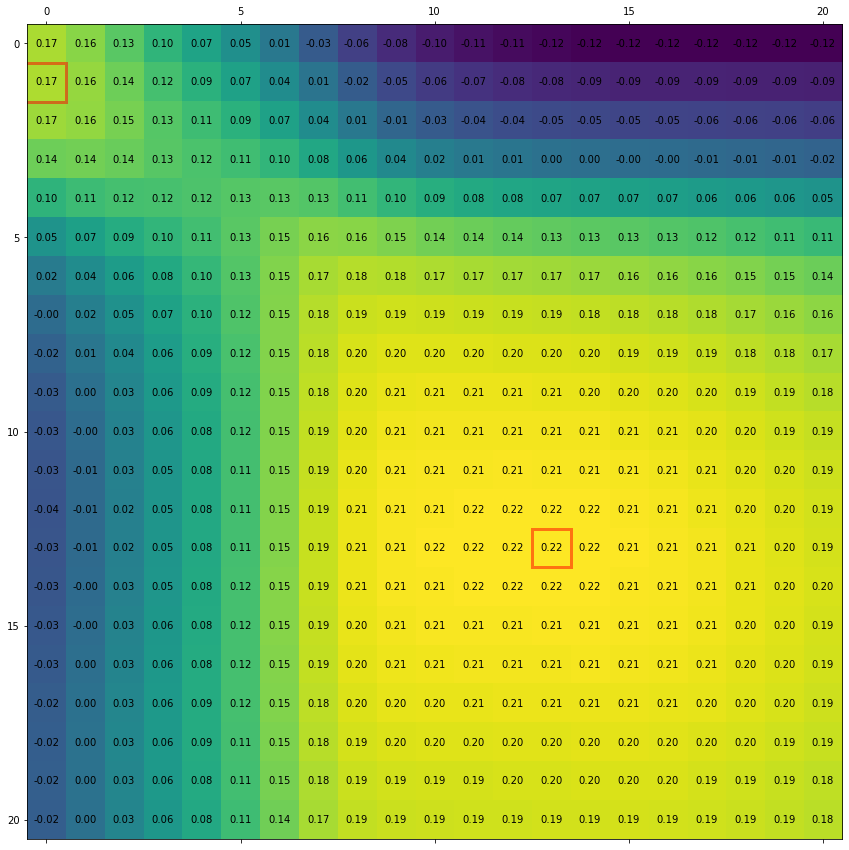

In [15]:
fix, ax = plt.subplots(figsize=(15,15))

df1 = dfs["danRer11"]
df2 = dfs["ASM318616v1"]
corr = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'].T
*outline, _ = get_outline(corr.values)
ax.plot(*outline, color=(1,0,0,.5), linewidth=3)
ax.matshow(corr.values)
for (i, j), z in np.ndenumerate(corr.values):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

                                 150.0      24.0   average  mm10 & GRCg6a
GM.5.0.Sox.0001               0.652695  0.412859  0.532777         1394.0
GM.5.0.Homeodomain.0001       0.820396  1.346897  1.083646         1654.0
GM.5.0.Mixed.0001            -1.489634 -1.739927 -1.614781           26.0
GM.5.0.Nuclear_receptor.0001  0.688814 -0.266827  0.210993         1115.0
GM.5.0.Mixed.0002             0.546472  1.219680  0.883076         1586.0
...                                ...       ...       ...            ...
GM.5.0.C2H2_ZF.0316           0.264632  0.523122  0.393877         1264.0
GM.5.0.C2H2_ZF.0317           1.113874  0.233577  0.673725         1478.0
GM.5.0.Ets.0049               0.491361  1.755256  1.123308         1671.0
GM.5.0.Unknown.0208          -1.039634 -0.887844 -0.963739          163.0
GM.5.0.Homeodomain_POU.0026  -0.614036  0.115116 -0.249460          687.0

[1796 rows x 4 columns]


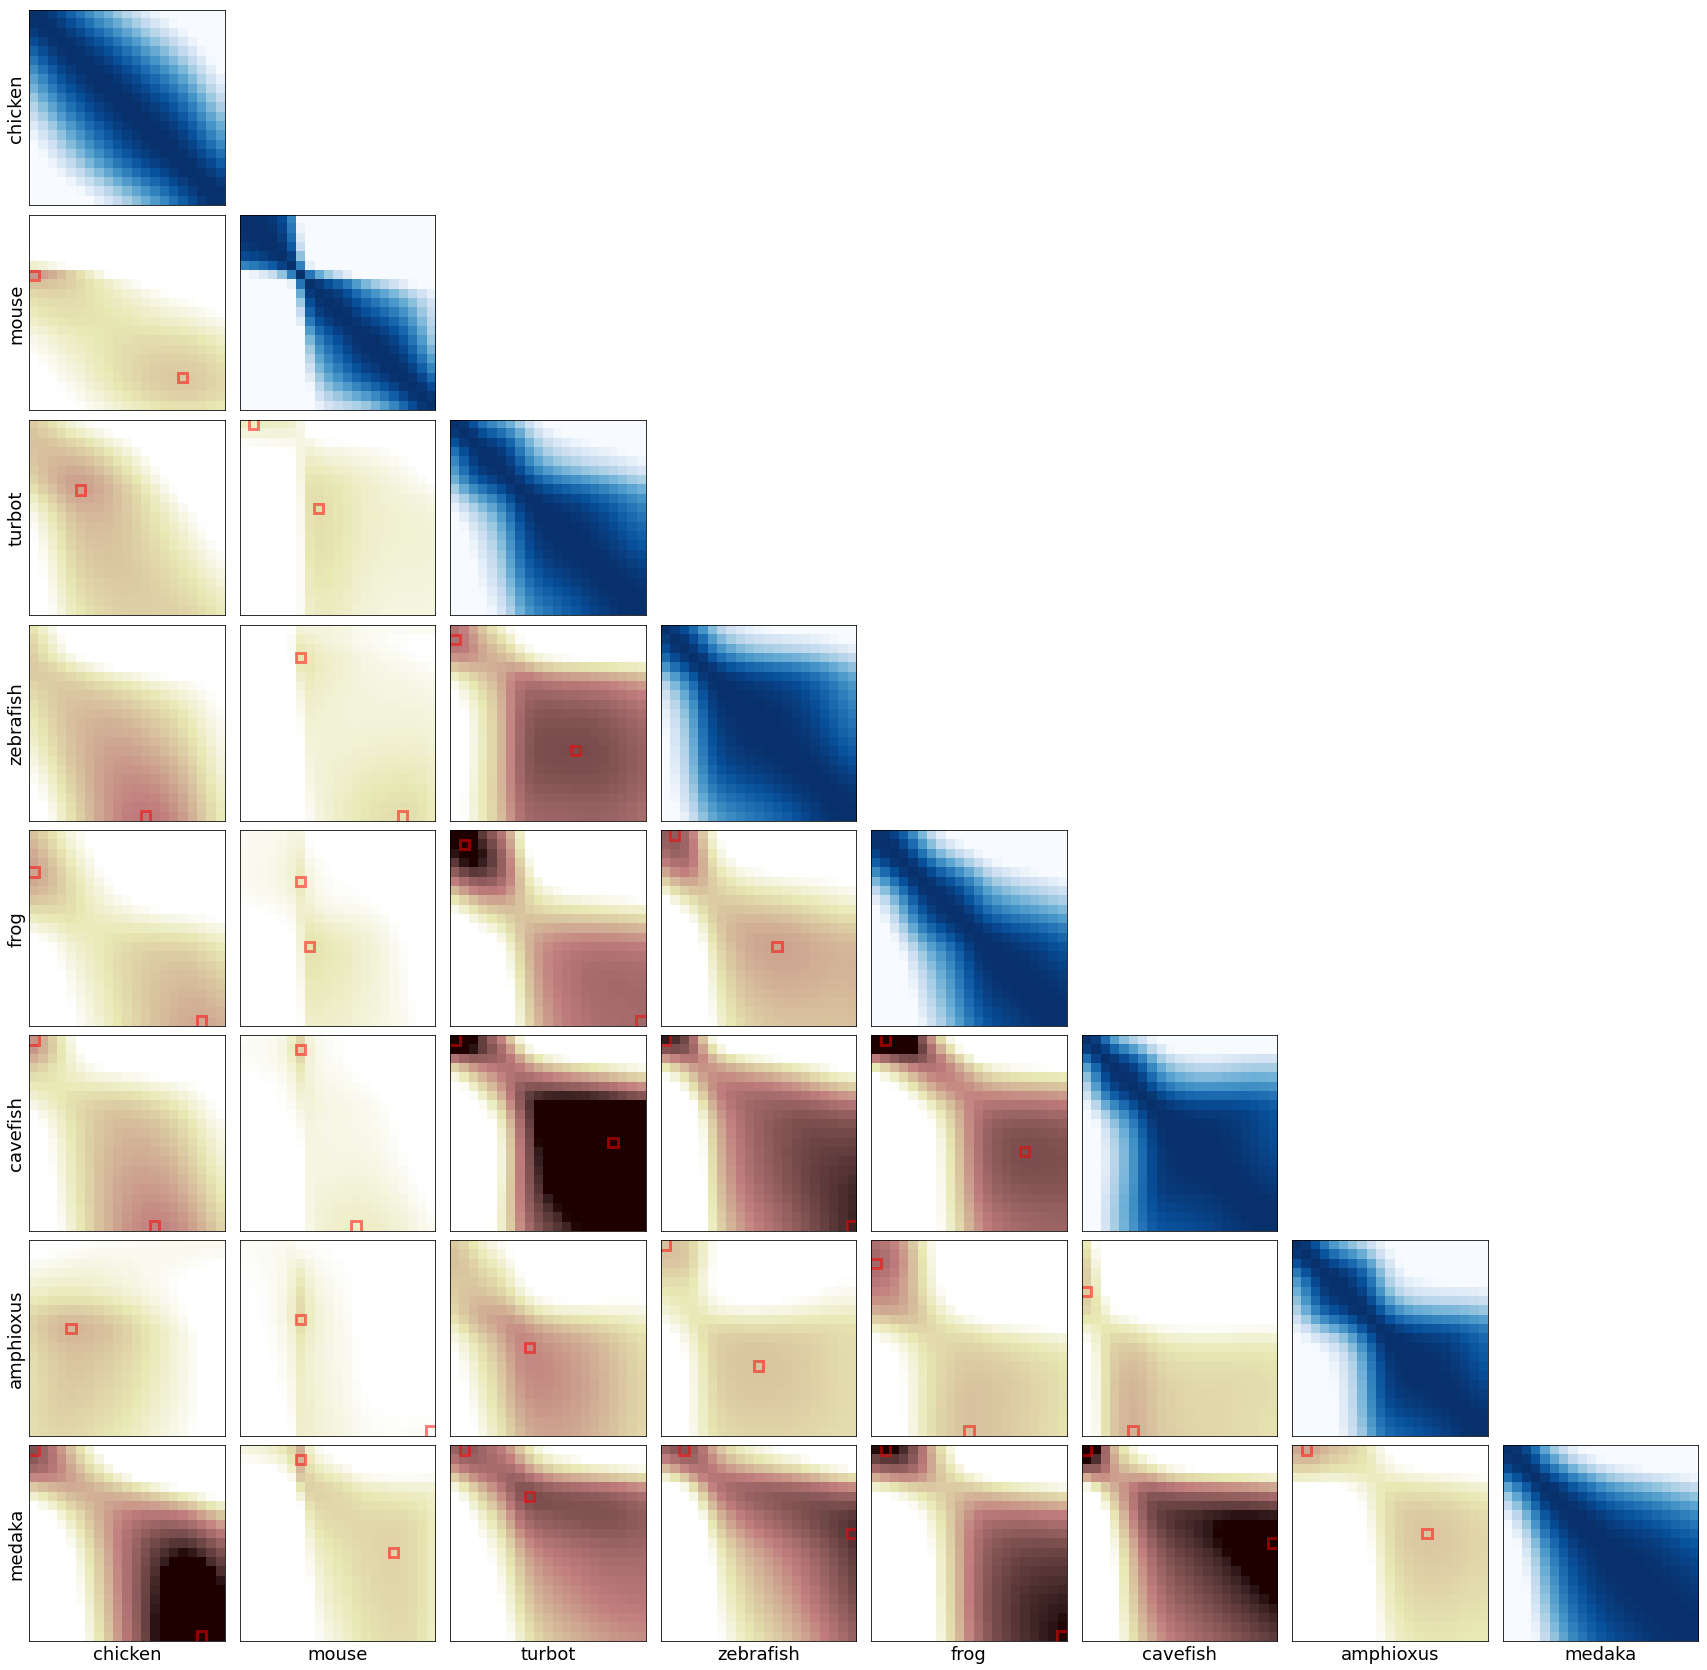

In [55]:
nr_assemblies = len(dfs.keys())

fig, axes = plt.subplots(figsize=(30, 30), nrows=len(dfs.keys()), ncols=len(dfs.keys()))
# fig, axes = plt.subplots(figsize=(15, 15), nrows=len(dfs.keys()), ncols=len(dfs.keys()))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

early = pd.DataFrame(index=dfs["danRer11"].index)
late = pd.DataFrame(index=dfs["danRer11"].index)

def get_bars(assembly):
    bars = dict()
    for phase, color in colors.items():
        start = timings.loc[assembly, phase]
        col_idx = list(timings.columns).index(phase)
        if col_idx != -1:
            for end_col in timings.columns[col_idx + 1:]:
                end = timings.loc[assembly, end_col]
                if not np.isnan(end):
                    bars[phase] = (start, end, color)
                    break
    return bars

for assembly_1_i, assembly_1 in enumerate(dfs.keys()):
    for assembly_2_i, assembly_2 in enumerate(dfs.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue
        df1 = dfs[assembly_1]
        df2 = dfs[assembly_2]
        corr = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'].T

        if assembly_1 == assembly_2:
            vmin, vmax = 0, 1
            cmap = "Blues"
        else:
            vmin, vmax = 0, 0.25
            cmap = "pink_r"
                
        im = ax.matshow(corr.values, aspect=len(df2.columns)/len(df1.columns), vmin=vmin, vmax=vmax, cmap=cmap)
        if assembly_1 != assembly_2:
            *outline, maxima = get_outline(corr.values)
            ax.plot(*outline, color=(1,0,0,.5), linewidth=3)
            if len(np.where(maxima)[0]) == 2:
                time_1_1, time_1_2 = np.where(maxima)[0]
                time_2_1, time_2_2 = np.where(maxima)[1]
                
                # TODO
                # z-score (not necessary with newest gimme)

                df_tmp = pd.concat([df1.iloc[:, time_1_1], df2.iloc[:, time_2_1]], axis=1)
                df_tmp[:] = zscore(df_tmp, axis=0)
                df_tmp["average"] = np.mean(df_tmp.values, axis=1)
                early[f"{assembly_1} & {assembly_2}"] = df_tmp["average"].rank(method='average')

#                 print(df1.iloc[:, time1])
#                 assert False
                
#             for (i, j), z in np.ndenumerate(corr.values):
#                 ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        if assembly_2_i == 0:
#             ax.set_yticks(range(corr.shape[0]), minor=False)
#             ax.set_yticklabels(corr.index, fontsize=14)
            ax.set_ylabel(ass2name[assembly_1], fontsize=18)
            
#             for start, stop, color in get_bars(assembly_1).values():
#                 p_start = float(corr.index[0])
#                 p_stop = float(corr.index[-1])
#                 stop  = list(sorted([0, 1, (stop - p_start) / (p_stop - p_start)]))[1]
#                 start = list(sorted([0, 1, (start  - p_start) / (p_stop - p_start)]))[1]
#                 add_bar_left(im, start, stop, color=color)

        if assembly_1_i == nr_assemblies - 1:
            ax.set_xlabel(ass2name[assembly_2], fontsize=18)
#             for start, stop, color in get_bars(assembly_2).values():
#                 p_start = float(corr.columns[0])
#                 p_stop = float(corr.columns[-1])
#                 stop  = list(sorted([0, 1, (stop - p_start) / (p_stop - p_start)]))[1]
#                 start = list(sorted([0, 1, (start  - p_start) / (p_stop - p_start)]))[1]
#                 add_bar_lower(im, start, stop, color=color)
        
#         # pretty colorbar
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.1)
#         plt.colorbar(im, cax=cax)

#         ax.set_aspect('equal')
# fig.colorbar(im, ax=axes[0])

In [47]:
df = pd.DataFrame({'C1': {'A': 5, 'B': 2, 'C': 3, 'D': 4},
                   'C2': {'A': 4, 'B': 1, 'C': 4, 'D': 2},
                   'C3': {'A': 3, 'B': 4, 'C': 6, 'D': 8}})

array([[ 1.34164079,  0.96225045, -1.1717002 ],
       [-1.34164079, -1.34715063, -0.65094455],
       [-0.4472136 ,  0.96225045,  0.39056673],
       [ 0.4472136 , -0.57735027,  1.43207802]])